# Imports

In [6]:
# ! pip install shap

In [2]:
import os
import sys
import time

PARENT_DIR = os.path.dirname(os.path.realpath(os.getcwd()))
sys.path.append(PARENT_DIR)

from tqdm import tqdm
from pathlib import Path
import pickle
import gc

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

from ak_data_loader import load_data, get_balanced_data, normalize_features

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import seaborn as sns
import matplotlib.pyplot as plt
# import wandb
# wandb.init(project='gene')

In [3]:
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from scipy.stats import entropy
from itertools import combinations
from sklearn.metrics import mutual_info_score, confusion_matrix

/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/gale/netapp/home2/aklein/miniconda3/envs/agp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading Data

In [4]:
_ct = "DG_Glut"
_testing_type = "imbalanced"
# FEATURE_TYPES = 

In [5]:
DMR_FEATURE_NAMES = ['2mo', '9mo', '18mo', '9mo-2mo', '18mo-9mo', '18mo-2mo', 'log2(gene_length)', 'log2(r_length)', 'log2(r_length/gene_length)', 'log2(distance)']

MCG_GENEBODY_FEATURE_NAMES = ['2mo', '9mo', '18mo', '9mo-2mo', '18mo-9mo', '18mo-2mo', 'log2(gene_length)','(9mo-2mo)*log2(gene_length)', 
                        '(18mo-2mo)*log2(gene_length)', '(18mo-9mo)*log2(gene_length)','DMG','corrected_pvalue']

MCH_GENEBODY_FEATURE_NAMES = ['2mo', '9mo', '18mo', '9mo-2mo', '18mo-9mo', '18mo-2mo', 'log2(gene_length)','(9mo-2mo)*log2(gene_length)', 
                        '(18mo-2mo)*log2(gene_length)', '(18mo-9mo)*log2(gene_length)','DMG','corrected_pvalue']

ATAC_FEATURE_NAMES = ['2mo', '9mo', '18mo', 'log2(9mo/2mo)', 'log2(18mo/9mo)', 'log2(18mo/2mo)', 'log2(gene_length)', 'log2(r_length)', 'log2(r_length/gene_length)', 'log2(distance)','DAR']

HIC_FEATURE_NAMES = [ 'Tanova', '2mo.Q', '9mo.Q', '18mo.Q','9mo-2mo.Q','18mo-9mo.Q', '18mo-2mo.Q',
                     'log2(gene_length)', 'log2(a_length)', 'log2(a_length/gene_length)','Diff_Loop'] #'Qanova', 'Eanova',,'2mo.T', '9mo.T', '18mo.T','9mo-2mo.T', '18mo-9mo.T', '18mo-2mo.T', 

DATA_FEATURE_NAMES = {
    'dmr': DMR_FEATURE_NAMES,
    'atac': ATAC_FEATURE_NAMES,
    'hic': HIC_FEATURE_NAMES,
    'mcg_genebody': MCG_GENEBODY_FEATURE_NAMES,
    'mch_genebody': MCH_GENEBODY_FEATURE_NAMES
}

In [6]:
data = load_data(y_val = "DEG", ct=_ct, filepath="../../data/", DATA_FEATURE_NAMES=DATA_FEATURE_NAMES)

# For balanced testing (Regular Cross Entropy Loss)
if _testing_type == "balanced":
    X_balanced, y_balanced = get_balanced_data(data, method='balanced', y_val="DEG")
    
# For imbalanced training (loss function must accomodate for this)
elif _testing_type == "imbalanced":
    X_balanced = data['X']
    y_balanced = data['y']
else: 
    raise("error")

FEATURE_TYPES = ['mcg', 'atac', 'hic', 'genebody']
for k, v in X_balanced.items():
        print(k, len(v))

Processed dmr data
Processed MCG genebody data
Processed MCH genebody data
Processed atac data
Processed hic data
dmr 8310
mcg_genebody 8310
mch_genebody 8310
atac 8310
hic 8310


## Making the genebody dataset

In [7]:
X_gb = X_balanced['mch_genebody'].copy()

In [8]:
for i in range(len(X_gb)): 
    num_entries = len(X_gb[i])
    if num_entries != 1: 
        temp_arr = [0]*12
        for j in range(num_entries): 
            for k in range(12): 
                if type(X_gb[i][j][k]) == float:
                    temp_arr[k] += X_gb[i][j][k]
                else: 
                    temp_arr[k] = bool(temp_arr[k])
                    temp_arr[k] |= X_gb[i][j][k]
        for k in range(12): 
            if type(temp_arr[k]) == float:
                temp_arr[k] /= num_entries
        X_gb[i] = [temp_arr]
X_gb = np.asarray(X_gb).squeeze()

In [9]:
y_balanced += 1

In [10]:
X_gb.shape

(8310, 12)

In [11]:
GENEBODY_FEATURE_NAMES = ['2mo', '9mo', '18mo', '9mo-2mo', '18mo-9mo', '18mo-2mo', 'log2(gene_length)','(9mo-2mo)*log2(gene_length)', 
                            '(18mo-2mo)*log2(gene_length)', '(18mo-9mo)*log2(gene_length)','DMG','corrected_pvalue']
X = pd.DataFrame(X_gb, columns = GENEBODY_FEATURE_NAMES)

In [12]:
# X = X.drop(columns = ['log2(gene_length)'])

In [13]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X_gb, y_balanced, test_size = 0.2, random_state = 13)
# normalize 
X_train, X_test = normalize_features(X_train, X_test)
kf = KFold(n_splits=5, shuffle=True, random_state=25)

In [16]:
# len(X_train)

6648

In [14]:
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
# class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

# XGBoost

In [59]:
# hyperport tutorial: 
space = {'max_depth': hp.quniform("max_depth", 3, 18, 1), 
        'gamma' : hp.uniform('gamma', 0.5, 5), 
        'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1), 
        'reg_lambda': hp.uniform('reg_lambda', 0, 1), 
        'n_estimators': hp.quniform('n_estimators', 50, 200, 5),
        'seed' : 13
        }

In [60]:
def objective(space): 
    xgb_mod = xgb.XGBClassifier(
        n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']),                         
        gamma = space['gamma'], reg_alpha=int(space['reg_alpha']), reg_lambda=space['reg_lambda'], 
        seed=space['seed'] )
    
    evaluation = [(X_train, y_train, X_test, y_test)]
    xgb_mod = xgb_mod.fit(X_train, y_train, sample_weight = sample_weights)
    
    pred = xgb_mod.predict(X_test)
    bal_accuracy = balanced_accuracy_score(y_test, pred)
    return {'loss' : -bal_accuracy, 'status' : STATUS_OK}

In [61]:
trials = Trials()

best_hyperparams = fmin(fn = objective, space = space, 
                         algo = tpe.suggest, 
                        max_evals = 200, trials = trials)

100%|██████████| 200/200 [00:50<00:00,  3.98trial/s, best loss: -0.49583279179988393]


In [62]:
best_hyperparams

{'gamma': 0.7681778140190296,
 'max_depth': 15.0,
 'n_estimators': 145.0,
 'reg_alpha': 86.0,
 'reg_lambda': 0.701545573193945}

In [70]:
# For default stuff
xgb_mod = xgb.XGBClassifier(max_depth=int(best_hyperparams['max_depth']), gamma=best_hyperparams['gamma'], 
                           n_estimators = int(best_hyperparams['n_estimators']), reg_alpha = int(best_hyperparams['reg_alpha']), 
                                             reg_lambda = best_hyperparams['reg_lambda'])
xgb_mod = xgb_mod.fit(X_train, y_train, sample_weight = sample_weights)

In [ ]:
# for hyperparameter tuning: 
# params_list

In [65]:
# # For default stuff
# xgb_mod = xgb.XGBClassifier(max_depth=10)
# xgb_mod = xgb_mod.fit(X_train, y_train, sample_weight = sample_weights)

In [80]:
y_probs = xgb_mod.predict_proba(X_train)
y_preds = xgb_mod.predict(X_train)

In [72]:
# y_probs

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

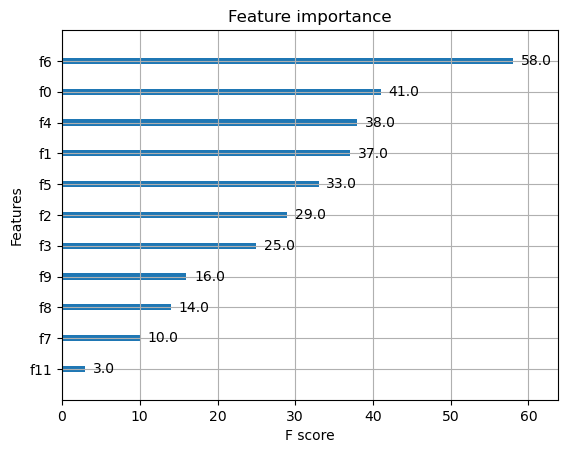

In [84]:
xgb.plot_importance(xgb_mod)

In [82]:
# acc = (y_preds == y_test).sum() / len(y_test) * 100
# print("model Accuracy: %.3f%%" %(acc))

acc = (y_preds == y_train).sum() / len(y_train) * 100
print("model Accuracy: %.3f%%" %(acc))

model Accuracy: 45.427%


In [83]:
pd.DataFrame(y_preds).value_counts()

0
0    2782
1    2552
2    1314
Name: count, dtype: int64

In [75]:
acc = accuracy_score(y_test, y_preds)
b_acc = balanced_accuracy_score(y_test, y_preds)
print("XGB Accuracy: %.2f%%" % (acc*100))
print("Balanced XGB Accuracy: %.2f%%" %(b_acc*100))

XGB Accuracy: 40.85%
Balanced XGB Accuracy: 49.58%


In [76]:
ccf = confusion_matrix(y_test, y_preds)
ccf.sum(axis=0)

array([727, 592, 343])

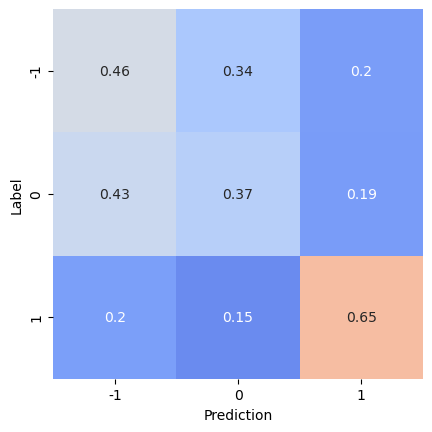

In [77]:
ccf = confusion_matrix(y_test, y_preds, normalize='true')
fig, ax = plt.subplots()
sns.heatmap(ccf, vmin=0, vmax=1, xticklabels = ['-1', '0', '1'], yticklabels = ['-1', '0', '1'], 
            square=True, cmap='coolwarm', annot=True, cbar = False, ax=ax)

ax.set_xlabel("Prediction")
ax.set_ylabel("Label")
plt.show()

In [78]:
def information_gain(labels, preds): 
    start_entropy = entropy(pd.DataFrame(y_test).value_counts(), base=2)
    ccf = confusion_matrix(labels, preds)
    conditional_entropy = (entropy(ccf, base=2, axis=0) * (ccf.sum(axis=0) / ccf.sum())).sum()
    return start_entropy - conditional_entropy 

In [79]:
max_gain = information_gain(y_test, y_test)
gain_ratio = information_gain(y_test, y_preds) / max_gain
print("Information Gain Ratio: %.4f bits" % (gain_ratio))

Information Gain Ratio: 0.0165 bits


In [27]:
pd_X = pd.DataFrame(X_train, columns = GENEBODY_FEATURE_NAMES)

In [29]:
explainer = shap.TreeExplainer(xgb_mod, pd_X) # , feature_perturbation='interventional', model_output="predict_proba")
shap_values = explainer(pd_X, check_additivity=False)

100%|===================| 13300/13308 [04:28<00:00]        

In [30]:
np.mean(y_test), np.mean(y_preds), np.mean(y_train)

(0.9306306306306307, 0.9495495495495495, 0.9458972046889089)

In [31]:
y_train[0]

1

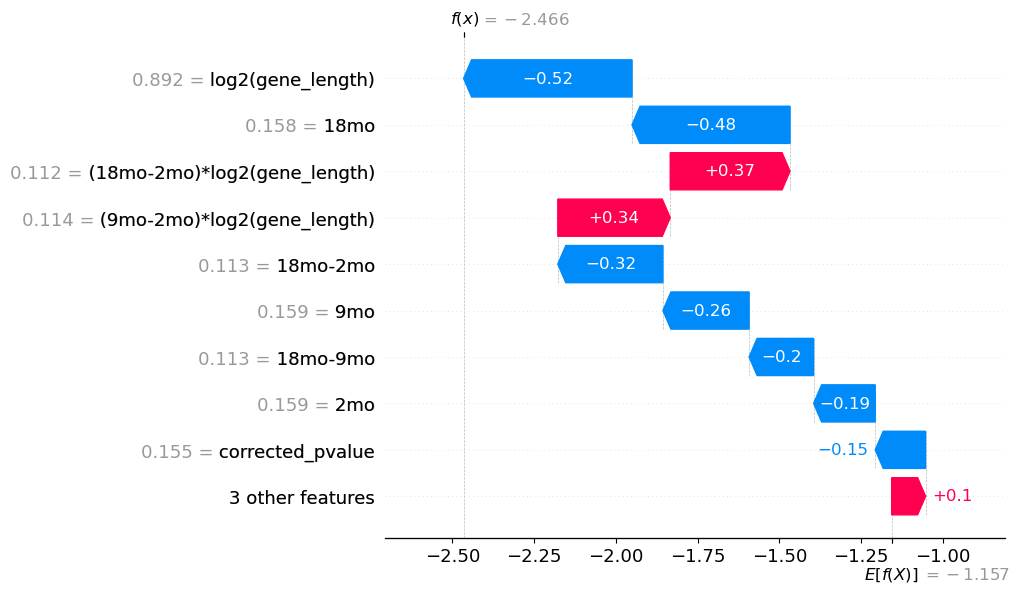

In [37]:
shap.plots.waterfall(shap_values[5, :, 0])

In [33]:
# shap_values.feature_names

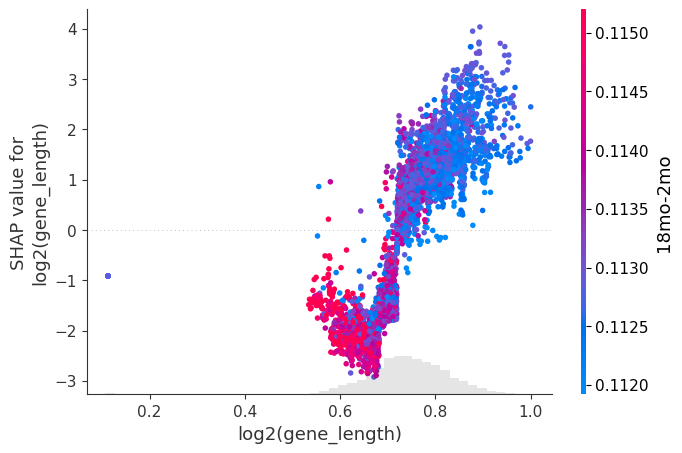

In [34]:
i = 2
shap.plots.scatter(shap_values[:, 'log2(gene_length)', i], color = shap_values[:, '18mo-2mo', i])

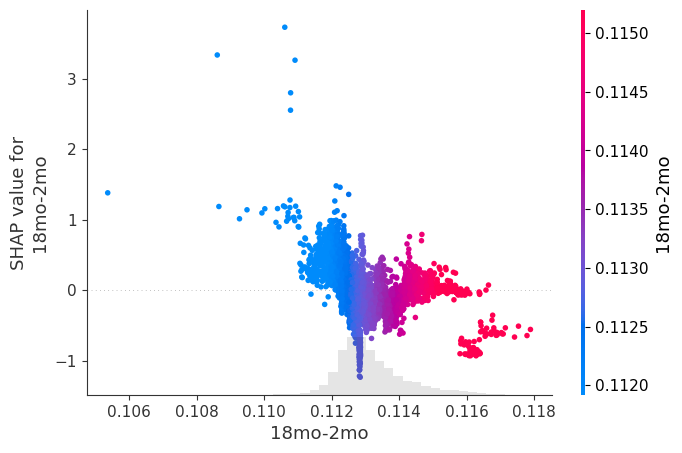

In [35]:
i = 2
shap.plots.scatter(shap_values[:, '18mo-2mo', i], color = shap_values[:, '18mo-2mo', i])

Down Regulated Importance


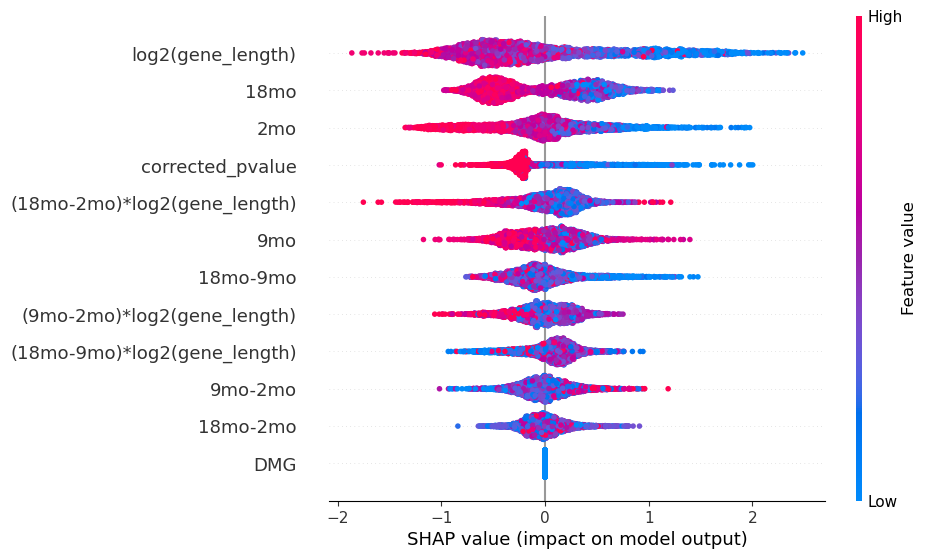

Non DEG Importance


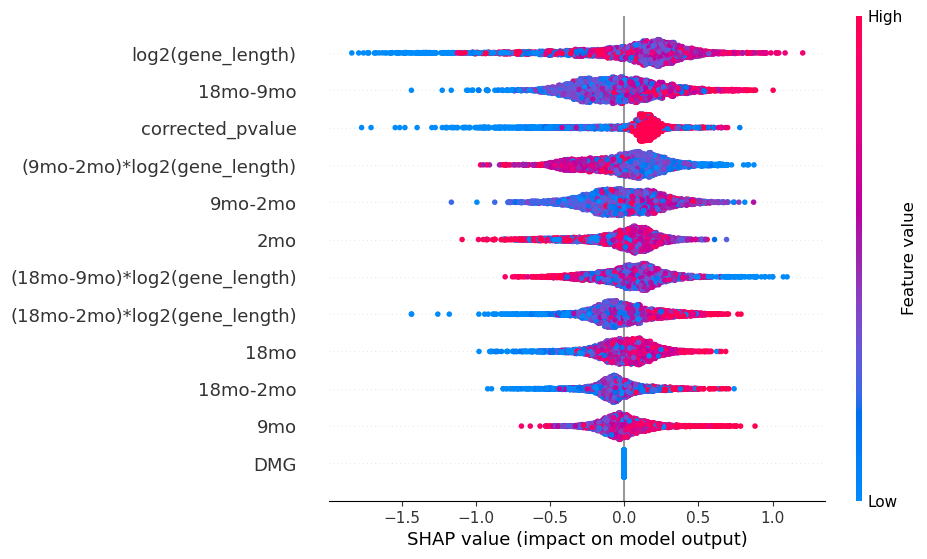

Up Regulated Importance


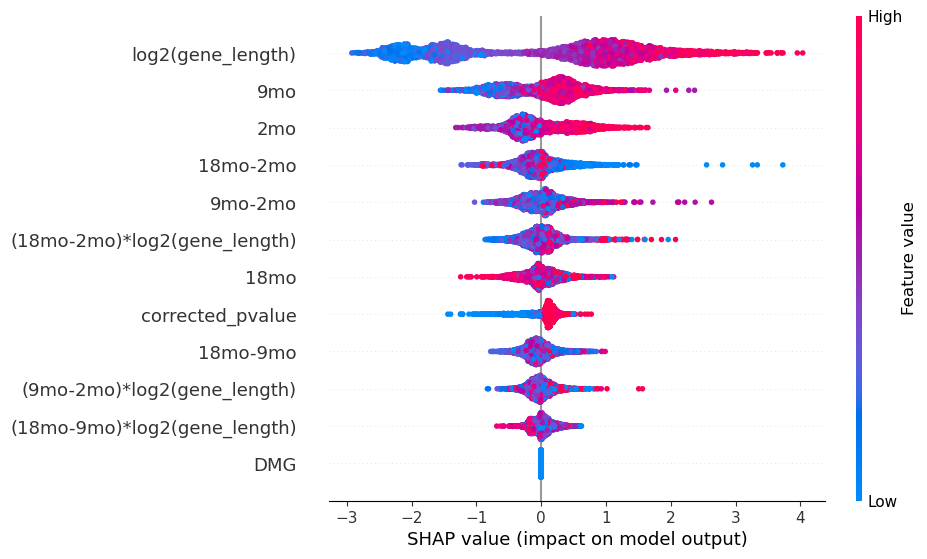

In [36]:
print("Down Regulated Importance")
shap.plots.beeswarm(shap_values[:, :, 0], max_display=20)
print("Non DEG Importance")
shap.plots.beeswarm(shap_values[:, :, 1], max_display=20)
print("Up Regulated Importance")
shap.plots.beeswarm(shap_values[:, :, 2], max_display=20)

# Playground

In [9]:
X, y = shap.datasets.california()

In [45]:
# X.head()

In [16]:
model = xgboost.XGBRegressor().fit(X, y)

In [246]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

In [29]:
# shap_values[0][0]

In [257]:
# shap.plots.waterfall(shap_values[0])

In [32]:
# does not work on jupyter lab
# shap.plots.force(shap_values[:10])

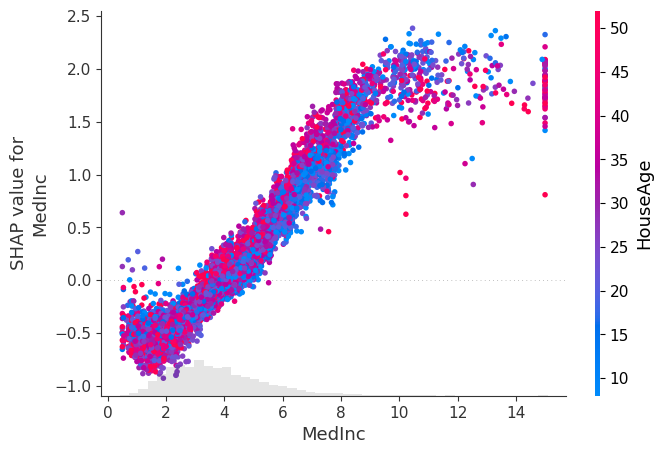

In [38]:
shap.plots.scatter(shap_values[:, "MedInc"], color=shap_values[:, "HouseAge"])

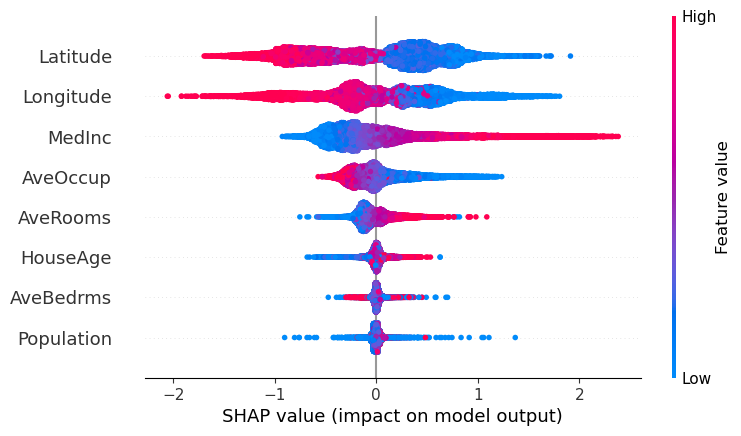

In [36]:
shap.plots.beeswarm(shap_values)

In [39]:
del X, y
del shap_values
del model, explainer